<a href="https://colab.research.google.com/github/Y-Srivaishnavi/simple_neural_architecture_search/blob/main/NAS_in_ANN_using_HAR_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Setup

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

This notebook demonstrates the workflow for building a deep learning model
using the Human Activity Recognition dataset.
Necessary libraries have been imported.


### 2. Data Collection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/G-project/datasets/har/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/G-project/datasets/har/train.csv')

In [ ]:
train_df.iloc[:5, 557:]

,"angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


Since dataset is too large to plot `sns.pairplot`, we have plotted the feature correlation.

### 3. Data Exploration and Visualization

Data shapes (rows, columns): (7352, 563)
Column names: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y', 'tBodyAcc-min()-Z', 'tBodyAcc-sma()', 'tBodyAcc-energy()-X', 'tBodyAcc-energy()-Y', 'tBodyAcc-energy()-Z', 'tBodyAcc-iqr()-X', 'tBodyAcc-iqr()-Y', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X', 'tBodyAcc-entropy()-Y', 'tBodyAcc-entropy()-Z', 'tBodyAcc-arCoeff()-X,1', 'tBodyAcc-arCoeff()-X,2', 'tBodyAcc-arCoeff()-X,3', 'tBodyAcc-arCoeff()-X,4', 'tBodyAcc-arCoeff()-Y,1', 'tBodyAcc-arCoeff()-Y,2', 'tBodyAcc-arCoeff()-Y,3', 'tBodyAcc-arCoeff()-Y,4', 'tBodyAcc-arCoeff()-Z,1', 'tBodyAcc-arCoeff()-Z,2', 'tBodyAcc-arCoeff()-Z,3', 'tBodyAcc-arCoeff()-Z,4', 'tBodyAcc-correlation()-X,Y', 'tBodyAcc-correlation()-X,Z', 'tBodyAcc-correlation()-Y,Z', 'tGravityAcc-mean()-

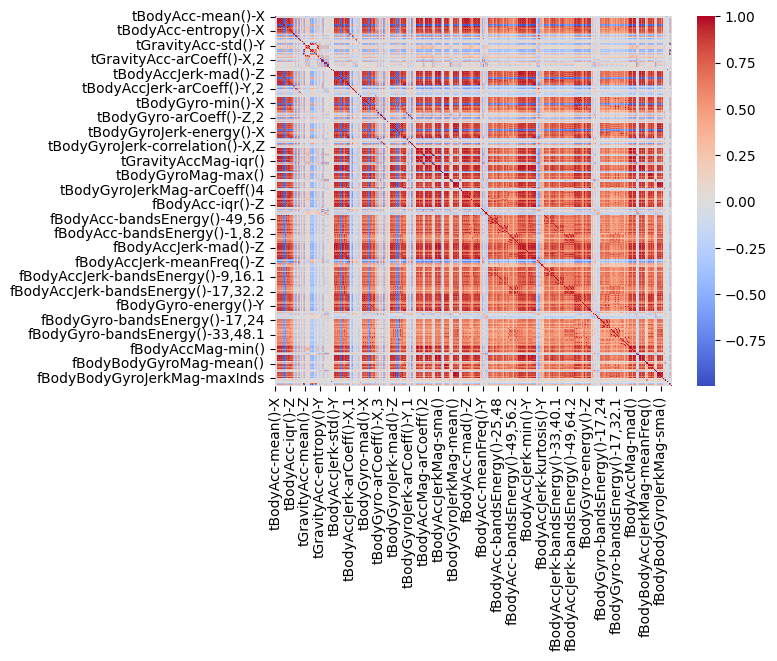

In [ ]:
import seaborn as sns

print("Data shapes (rows, columns):", train_df.shape)
print("Column names:", train_df.columns.tolist())
# Compute the correlation matrix
corr = train_df.drop('Activity', axis=1).corr()
sns.heatmap(corr, cmap='coolwarm')
plt.show()

### 4. Data Preprocessing

Divide data into dependent and independent features

In [ ]:
X_train = train_df.drop('Activity', axis=1)
y_train = train_df['Activity']

In [ ]:
y_train.unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

Since softmax is being used, we need to perform one-hot encoding on `y_train`

In [ ]:
y_train_soft = pd.DataFrame.to_numpy(pd.get_dummies(y_train))

In [ ]:
y_train_soft

array([[False, False,  True, False, False, False],
       [False, False,  True, False, False, False],
       [False, False,  True, False, False, False],
       ...,
       [False, False, False, False, False,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False,  True]])

Model can be better trained when data is scaled.

In [ ]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_s = ss.fit_transform(X_train)
X_train_s

array([[ 0.20064157, -0.0636826 , -0.41962845, ...,  0.40794614,
        -0.00756789, -1.8288513 ],
       [ 0.05594788,  0.03148567, -0.25390836, ...,  0.40911698,
         0.00787517, -1.8288513 ],
       [ 0.07351535, -0.04341648, -0.07629468, ...,  0.4102883 ,
         0.02650234, -1.8288513 ],
       ...,
       [-0.01566765,  0.0167814 ,  1.13222107, ...,  0.64059683,
         0.34870928,  1.4025149 ],
       [ 0.21586648, -0.02812252, -0.86770988, ...,  0.63147758,
         0.29327564,  1.4025149 ],
       [ 1.09620157,  0.12919873, -1.67268082, ...,  0.63274259,
         0.33396081,  1.4025149 ]])

In [ ]:
X_train_s.shape

(7352, 562)

Perform above processes for test data.

In [ ]:
X_test = ss.transform(test_df.drop('Activity', axis=1))
y_test = pd.DataFrame.to_numpy(pd.get_dummies(test_df['Activity']))

### 5. Model Development and Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, PReLU
from tensorflow.keras.layers import Dropout

Define model architecture. Below parameters were taken after manual experimentation with different values.

In [ ]:
model = Sequential()
model.add(Dense(15, activation = 'relu', input_shape = (X_train.shape[1], )))
model.add(Dropout(0.5))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=6, activation='softmax'))

Compile model.

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Define early stop criteria to save training time.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model_history = model.fit(X_train_s, y_train_soft, validation_split=0.2, batch_size=10, epochs=1000, callbacks=early_stop)

Epoch 1/1000
589/589 [==============================] - 2s 3ms/step - loss: 0.7971 - accuracy: 0.6438 - val_loss: 0.2821 - val_accuracy: 0.9239
Epoch 2/1000
589/589 [==============================] - 2s 3ms/step - loss: 0.4733 - accuracy: 0.7929 - val_loss: 0.2306 - val_accuracy: 0.9184
Epoch 3/1000
589/589 [==============================] - 1s 2ms/step - loss: 0.3852 - accuracy: 0.8442 - val_loss: 0.1914 - val_accuracy: 0.9320
Epoch 4/1000
589/589 [==============================] - 2s 3ms/step - loss: 0.3293 - accuracy: 0.8684 - val_loss: 0.1560 - val_accuracy: 0.9381
Epoch 5/1000
589/589 [==============================] - 2s 4ms/step - loss: 0.2947 - accuracy: 0.8817 - val_loss: 0.1530 - val_accuracy: 0.9402
Epoch 6/1000
589/589 [==============================] - 1s 2ms/step - loss: 0.2889 - accuracy: 0.8886 - val_loss: 0.1652 - val_accuracy: 0.9368
Epoch 7/1000
589/589 [==============================] - 1s 2ms/step - loss: 0.2697 - accuracy: 0.8942 - val_loss: 0.2176 - val_accuracy:

Training completed. Below are the criteria used to measure model's training performance.

In [ ]:
model_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### 6. Model Evaluation

In [ ]:
y_pred = model.predict(X_test)
y_pred = (y_pred >=0.5)

230/230 [==============================] - 0s 1ms/step


In [ ]:
y_pred = y_pred.astype(int)
y_pred

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

Evaluate model using accuracy, recall, and f1-score

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print('-'*40)
print("Confusion Matrix:", multilabel_confusion_matrix(y_test, y_pred))
print('-'*40)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9408324265505985
----------------------------------------
Confusion Matrix: [[[5945    0]
  [  11 1396]]

 [[5682  384]
  [   3 1283]]

 [[5975    3]
  [ 375  999]]

 [[6088   38]
  [   0 1226]]

 [[6366    0]
  [  43  943]]

 [[6278    1]
  [   3 1070]]]
----------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00      1407
           1       0.77      1.00      0.87      1286
           2       1.00      0.73      0.84      1374
           3       0.97      1.00      0.98      1226
           4       1.00      0.96      0.98       986
           5       1.00      1.00      1.00      1073

   micro avg       0.94      0.94      0.94      7352
   macro avg       0.96      0.95      0.94      7352
weighted avg       0.95      0.94      0.94      7352
 samples avg       0.94      0.94      0.94      7352



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 7. Model Performance Visualization

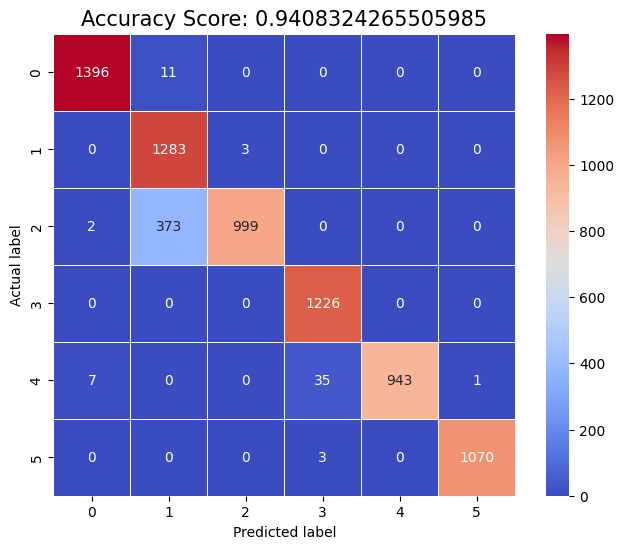

In [ ]:
from sklearn.metrics import confusion_matrix

score = accuracy_score(y_test, y_pred)
# Confusion Matrix Visualization
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap ='coolwarm')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title(f'Accuracy Score: {score}', size = 15)
plt.show()

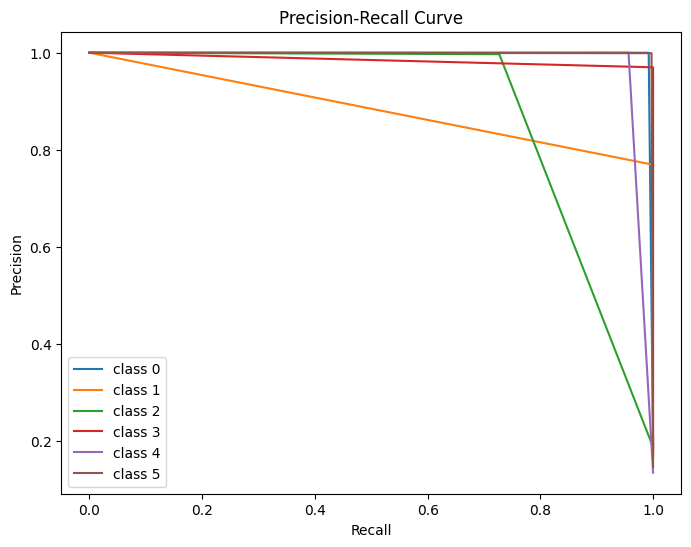

In [ ]:
from sklearn.metrics import precision_recall_curve

precision = {}
recall = {}
thresholds = {}
for i in range(6):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test[:, i], y_pred[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.plot(recall[i], precision[i], label='class {}'.format(i))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

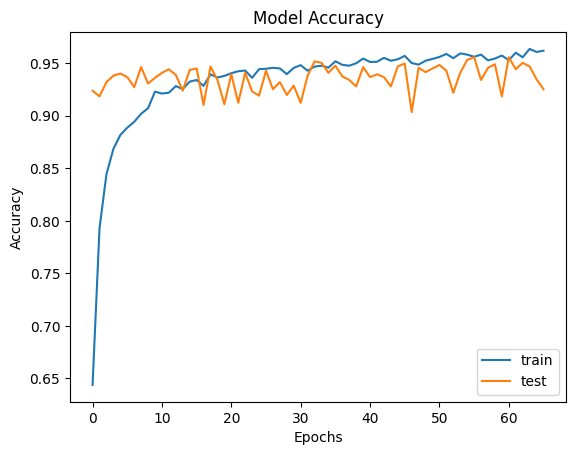

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

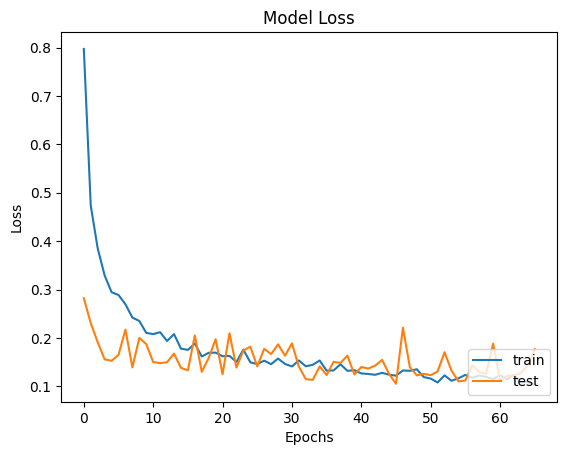

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()